In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import scipy.signal as spsig
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from pasna2021 import PasnaFly
from pasna2021 import utils as pu

import warnings
warnings.filterwarnings('ignore')

# Get file names of ROI CSVs to import

In [2]:
data_dir = '../data/wt'
roi_csv_fns = sorted([x for x in os.listdir(data_dir) if x[-3:]=="csv" and x[0]!="."])

# Exclude flies

In [3]:
exclusion_flies = ['A_02', # didn't hatch
                   'A_07', # mini early episode
                   'A_09', # didn't hatch
                   'B_01', # early movement
                   'B_03', # early movement
                   'B_06', # early movement
                   'B_07', # bad ROI
                   'B_09', # early movement
                   'B_10', # first peak ambiguous
                   'B_11', # lots of movement
                   'B_18', # early movement
                   'B_19', # noisy -> peaks ambiguous
                   'B_20'  # didn't hatch
                  ] 
roi_csv_fns = [x for x in roi_csv_fns if not any(exc in x for exc in exclusion_flies)]
roi_csv_fns, len(roi_csv_fns)

(['20210307_A_01.csv',
  '20210307_A_03.csv',
  '20210307_A_04.csv',
  '20210307_A_05.csv',
  '20210307_A_06.csv',
  '20210307_A_08.csv',
  '20210307_A_10.csv',
  '20210307_A_11.csv',
  '20210307_A_12.csv',
  '20210307_A_13.csv',
  '20210307_A_14.csv',
  '20210307_A_15.csv',
  '20210307_B_02.csv',
  '20210307_B_04.csv',
  '20210307_B_05.csv',
  '20210307_B_08.csv',
  '20210307_B_12.csv',
  '20210307_B_13.csv',
  '20210307_B_14.csv',
  '20210307_B_15.csv',
  '20210307_B_16.csv',
  '20210307_B_17.csv',
  '20210307_B_21.csv'],
 23)

# Model trace plots (Figure 1C)

In [4]:
models = ['20210307_B_08', '20210307_B_15', '20210307_A_14']
model_roi_csv_fns = [x for x in os.listdir(data_dir) if any(model in x for model in models)]
model_roi_csv_fns

['20210307_A_14.csv', '20210307_B_08.csv', '20210307_B_15.csv']

In [5]:
model_flies = [PasnaFly(os.path.join(data_dir, csv_fn), trim_data=True) for csv_fn in model_roi_csv_fns]
_=[fly.detect_peaks() for fly in model_flies]
n_model_flies = len(model_flies)

Text(0, 0.5, 'dF/F')

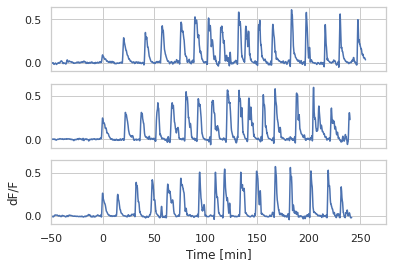

In [6]:
fig_apart,ax = plt.subplots(n_model_flies, 1, figsize=None, sharex=True, sharey=True)

for i in range(n_model_flies):
    fly = model_flies[i]
    time_from_1st_peak = fly.time - fly.peak_times[0]
    ax[i].plot(time_from_1st_peak, fly.savgol)
ax[i].set_xlim(left=-50)
ax[i].set_xlabel('Time [min]')
ax[i].set_ylabel('dF/F')

# Create PasnaFly objects and detect peaks

In [7]:
flies = [PasnaFly(os.path.join(data_dir, csv_fn), trim_data=True) for csv_fn in roi_csv_fns]
_ = [fly.detect_peaks() for fly in flies]

### Plot raw and filtered traces, and mark detected peaks and trim time point

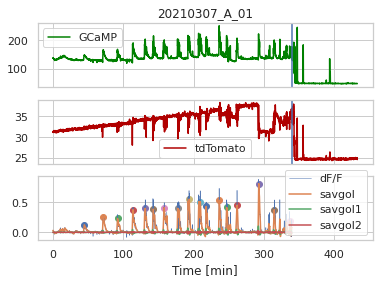

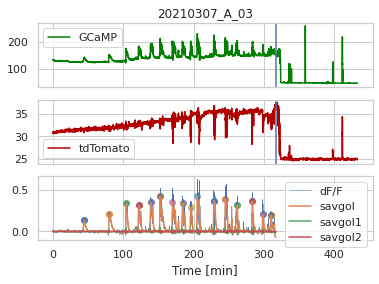

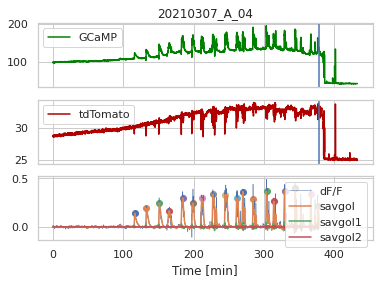

In [8]:
# Only plotting a few as demo; remove '[0:3]' to plot all flies
figs = [fly.plot(raw=True, figsize=None) for fly in flies[0:3]]

# Heatmap of dF/F (Figure 1 D)

Align to first peak and sort by 2nd peak time

In [9]:
p_times_aligned = [(fly.peak_times - fly.peak_times[0]) for fly in flies]
sort_2nd_peak = np.argsort([fly[1] for fly in p_times_aligned])

In [10]:
traces = [fly.savgol[fly.peak_idxes[0]-200:] for fly in flies]
times = [fly.time[fly.peak_idxes[0]-200:]-fly.time[fly.peak_idxes[0]] for fly in flies]
times_std, traces_std = pu.align_traces_to_standardized_timestamp(times, traces, trim=True)

Text(0.5, 12.5, 'Time (min)')

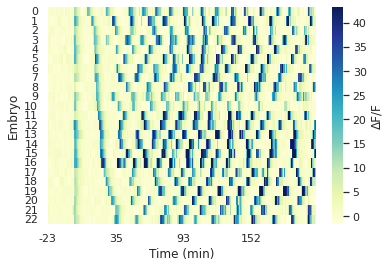

In [11]:
plt.close('all')
sns.heatmap(pd.DataFrame(data=traces_std[sort_2nd_peak]*100, columns=np.round(times_std).astype(int)), robust=True, cmap='YlGnBu', yticklabels=True, xticklabels=500, cbar=True, cbar_kws={'label':'\u0394F/F'})
plt.ylabel('Embryo')
plt.xlabel('Time (min)')

# Inter peak interval and peak amplitudes (Figure 1 E,F)

In [12]:
n_peaks_analyzed = 12

fly_names = [fly.name for fly in flies]
names_idx = pd.Index(fly_names, name='fly')

peak_intervals = pu.uneven_list2d_to_np([fly.peak_intervals for fly in flies])
intervals_mean = np.nanmean(peak_intervals, axis=0)
intervals_sem = pu.nansem(peak_intervals, axis=0)

df_intervals         = pd.DataFrame(data=peak_intervals, columns=pd.Index(range(1,peak_intervals.shape[1]+1), name='intNum'), index=names_idx)
df_intervals_trimmed = df_intervals.loc[:,range(1,n_peaks_analyzed)]
df_intervals_long    = df_intervals.reset_index(level=0).melt(id_vars='fly', value_name='intWidth')
df_intervals_long_trimmed = df_intervals_trimmed.reset_index(level=0).melt(id_vars='fly', value_name='intWidth')

In [13]:
peak_amplitudes = pu.uneven_list2d_to_np([fly.peak_amplitudes for fly in flies])*100
amps_mean = np.nanmean(peak_amplitudes, axis=0)
amps_sem = pu.nansem(peak_amplitudes, axis=0)

df_amps         = pd.DataFrame(data=peak_amplitudes, columns=pd.Index(range(1,peak_amplitudes.shape[1]+1), name='peakNum'), index=names_idx)
df_amps_trimmed      = df_amps.loc[:,range(1,n_peaks_analyzed+1)]
df_amps_long         = df_amps.reset_index(level=0).melt(id_vars='fly', value_name='peakAmplitude')
df_amps_long_trimmed = df_amps_trimmed.reset_index(level=0).melt(id_vars='fly', value_name='peakAmplitude')

In [14]:
# Compute mean and confidence intervals
ci = 95

m_int, ci_lo_int, ci_hi_int = pu.mean_ci(df_intervals_trimmed, ci=ci, bootstrap=True)
int_stats = pd.DataFrame(np.vstack([m_int, ci_lo_int, ci_hi_int]).T, index=pd.Index(data=range(1,len(m_int)+1),name='interval'), columns=['mean', 'ci95lo', 'ci95hi'])

m_amp, ci_lo_amp, ci_hi_amp = pu.mean_ci(df_amps_trimmed, ci=ci, bootstrap=True)
amp_stats = pd.DataFrame(np.vstack([m_amp, ci_lo_amp, ci_hi_amp]).T, index=pd.Index(data=range(1,len(m_amp)+1),name='peak'), columns=['mean', 'ci95lo', 'ci95hi'])

Text(0, 0.5, 'Interval length [min]')

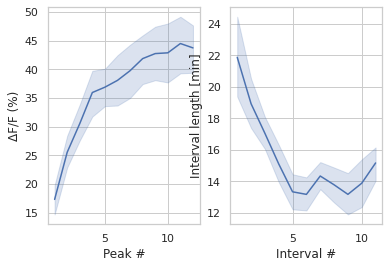

In [15]:
plt.close('all')
fig,ax = plt.subplots(1, 2, figsize=None, sharex=False)
sns.lineplot(data=df_amps_long_trimmed, x='peakNum', y='peakAmplitude', ci=95, ax=ax[0])
ax[0].set_xlabel('Peak #')
ax[0].set_ylabel('\u0394F/F (%)')
sns.lineplot(data=df_intervals_long_trimmed, x='intNum', y='intWidth', ci=95, ax=ax[1])
ax[1].set_xlabel('Interval #')
ax[1].set_ylabel('Interval length [min]')

# Sterotypy of episode intervals (Figure S1 D)

We assessed the extent to which PaSNA episodes occurred with stereotyped interpeak intervals by comparing the episode interval distributions of embryos to those generated under a null model.  Under the null model, episodes corresponding to each real embryo occurred randomly following a Poisson process with a rate parameter equal to the mean rate of the first twelve episodes in the real embryo. In our Monte Carlo sampling of interpeak intervals, we rejected those under 500 seconds, consistent with the minimum peak distance imposed in our peak detection algorithm.  We sampled 1,000,000 model embryos for each of 23 real embryos such that more than 500,000 remained after the rejections.  We then computed the root mean squared error (RMSE) from the mean for each model dataset of 23 embryos, and the resulting distribution was compared against the RMSE computed for each peak in the real dataset.  We assessed significance by examining how many model datasets had RMSE lower than that of each peak in the real dataset, and corrected for multiple comparisons using the Holm-Bonferroni method.

In [16]:
# Real sum of squares for each interval
rmse_real_intervals = np.sqrt(np.sum(np.square(df_intervals_trimmed - df_intervals_trimmed.mean()), axis=0)/len(flies))

In [17]:
# For each fly, simulate 11 intervals using exponential distribution(scale), then MCMC reject intervals under 500 seconds
min_peak_distance = 500/60 #minutes

B = 1000000
rand_intervals = []
for i in range(len(flies)):
    fly = flies[i]
    fly_mean_interval = (fly.peak_times[n_peaks_analyzed-1] - fly.peak_times[0]) / (n_peaks_analyzed-1)
    sampled_intervals = np.random.exponential(fly_mean_interval, size=B)
    rand_intervals.append(sampled_intervals[sampled_intervals>min_peak_distance])

B_culled = np.min([len(x) for x in rand_intervals])
rand_intervals_culled = np.asarray([x[:B_culled] for x in rand_intervals])
rand_intervals_culled = rand_intervals_culled.T.reshape(B_culled, len(flies))
rmse_rand_intervals = np.sqrt(np.sum(np.square(rand_intervals_culled - np.mean(rand_intervals_culled, axis=1).reshape(B_culled, 1)), axis=1)/len(flies))
rmse_rand_mean = np.mean(rmse_rand_intervals)
rmse_rand_std = np.std(rmse_rand_intervals)
p_vals = 1 - np.sum(rmse_rand_intervals.reshape(-1,1) > rmse_real_intervals.to_numpy().reshape(1,-1), axis=0) / B_culled

rmse_rand_mean, rmse_rand_std, multipletests(p_vals, alpha=0.05, method='holm')

(14.691919282716897,
 4.218947343115129,
 (array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]),
  array([1.94143100e-03, 3.37314266e-05, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.24876178e-05, 0.00000000e+00]),
  0.004652171732197341,
  0.004545454545454546))

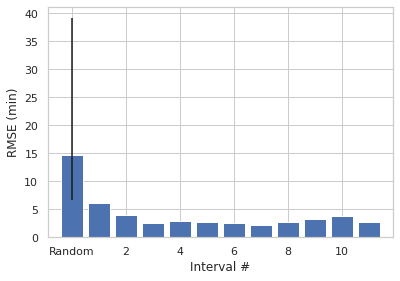

In [18]:
fig = plt.figure()
cilo, cihi = np.percentile(rmse_rand_intervals.flatten(), [2.5, 97.5])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x=range(0, n_peaks_analyzed), height=np.insert(rmse_real_intervals.values, 0, rmse_rand_mean), yerr=np.asarray([[cilo, cihi]] + [[0,0]] * (n_peaks_analyzed-1)).T, label='Real intervals')
ax.set_xlim([-0.9,n_peaks_analyzed-0.1])
ax.set_xlabel('Interval #')
ax.set_ylabel('RMSE (min)')
_=ax.set_xticklabels(['', 'Random', '2', '4', '6', '8', '10'])

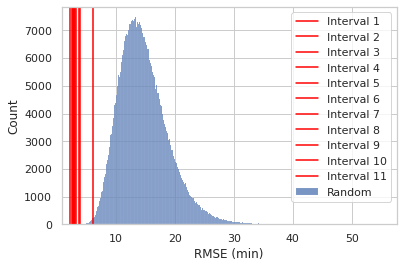

In [19]:
plt.figure()
sns.histplot(rmse_rand_intervals.flatten(), label='Random')
[plt.axvline(rmse_real_int, color='red', label=f'Interval {i}') for rmse_real_int,i in zip(rmse_real_intervals, range(1,n_peaks_analyzed))]
_=plt.xlabel('RMSE (min)')
plt.legend()